In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from itertools import cycle
import gc

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
# reading the train data set
# using the robiks cube data
train = pd.read_parquet('/kaggle/input/ubiquant-parquet/train_low_mem.parquet')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                #    df[col] = df[col].astype(np.float32)
                #else:
                df[col] = df[col].astype(np.float16)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 3642.99 MB
Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%


In [5]:
# the first five rows of the df

train.head(5)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0.0,2.0,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0.0,6.0,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0.0,7.0,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0.0,8.0,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [6]:
# unique investment ids
investment_id = 'investment_id'
train[investment_id].nunique()

2788

In [7]:
group=train.groupby('investment_id')

In [8]:
# find the shape of the data
train.shape

(3141410, 304)

In [9]:
train.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3141410.0,3141410.0,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,NaN,NaN,NaN,1.633644e-03,-1.258850e-02,8.499146e-03,-1.992798e-02,-5.428314e-03,-3.021240e-03,1.940727e-03,...,1.258850e-02,8.964539e-04,-6.500244e-03,2.836227e-03,-4.730225e-03,NaN,-1.508713e-03,-7.053375e-03,-4.215240e-03,-4.329681e-03
std,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.0,0.0,-9.421875e+00,-1.765625e+01,-6.578125e+00,-8.640625e+00,-1.800000e+01,-4.000000e+00,-8.835938e+00,-6.382812e+00,...,-9.273438e+00,-6.359375e+00,-8.187500e+00,-2.400000e+01,-1.497656e+01,-9.351562e+00,-7.367188e+00,-7.578125e+00,-6.707031e+00,-1.028125e+01
25%,353.0,952.0,-5.004883e-01,-4.072266e-01,-6.811523e-01,-6.533203e-01,-4.497070e-01,-3.532715e-01,-7.070312e-01,-7.910156e-01,...,-6.035156e-01,-8.354492e-01,-6.982422e-01,-1.376953e-01,-9.399414e-01,-5.146484e-01,-9.575195e-01,-7.241211e-01,-8.164062e-01,-5.078125e-01
50%,704.0,1882.0,-9.716797e-02,2.431641e-01,-4.867554e-02,4.351807e-02,-2.639160e-01,-1.909180e-01,-2.145386e-02,1.438141e-02,...,6.085205e-02,-2.022705e-01,-1.910400e-01,2.164307e-01,2.087402e-01,-2.907715e-01,6.954193e-03,-1.650391e-01,2.301025e-02,-2.824707e-01
75%,975.0,2830.0,3.571777e-01,6.650391e-01,6.088867e-01,6.586914e-01,7.763672e-02,2.784729e-02,6.835938e-01,8.007812e-01,...,6.884766e-01,9.038086e-01,4.841309e-01,5.087891e-01,8.618164e-01,1.275635e-01,9.501953e-01,6.098633e-01,7.983398e-01,1.411133e-01
max,1219.0,3772.0,1.203906e+01,7.843750e+00,8.710938e+00,8.007812e+00,4.706250e+01,7.662500e+01,7.644531e+00,6.777344e+00,...,9.296875e+00,9.726562e+00,2.231250e+01,6.585938e+00,6.976562e+00,6.140625e+01,7.679688e+00,1.242188e+01,7.003906e+00,4.337500e+01


In [10]:
# confirm for nulls
train.isnull().sum()

row_id           0
time_id          0
investment_id    0
target           0
f_0              0
                ..
f_295            0
f_296            0
f_297            0
f_298            0
f_299            0
Length: 304, dtype: int64

In [11]:
# df information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(303)
memory usage: 1.9 GB


In [12]:
# what are the columns corr

# corr = train.corr()

In [13]:
# plot the correlation in a heat map
# Yellow colors indicates a strong correlation
# plt.figure(figsize=(20,18))
# sns.heatmap(corr,cmap='viridis',annot=False)
# plt.xticks(rotation = 90)
# plt.show()

In [14]:
columns = np.array(train.columns.drop(['row_id', 'time_id', 'investment_id', 'target']))

In [15]:
# targets are the outputs
df_y = train['target']

Mapping integer input tokens into indexed integer output

Text(0, 0.5, 'f_27')

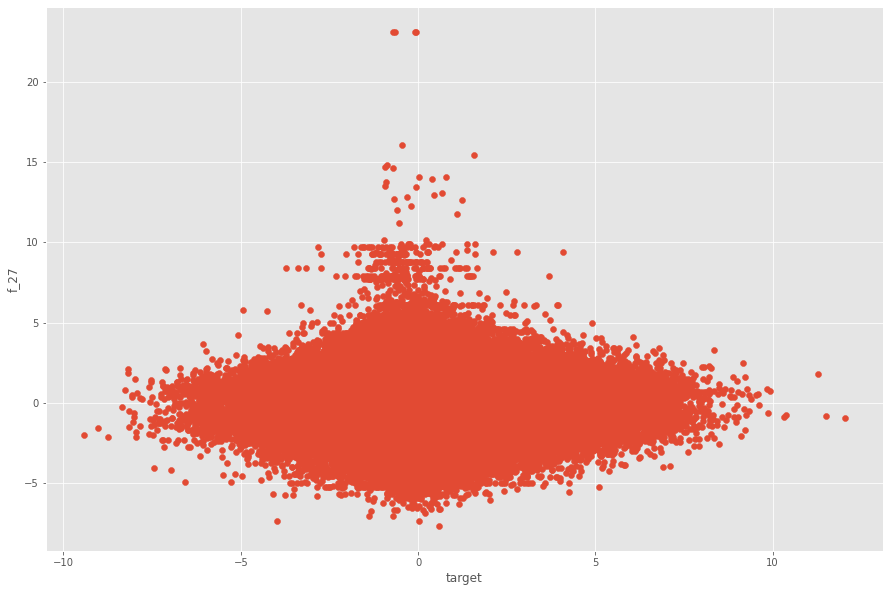

In [16]:
#  plot a  random feature against the target
feature =columns[np.random.randint(0,len(columns))]
plt.figure(figsize=(15, 10))
plt.scatter(train['target'],train[feature])
plt.xlabel('target')
plt.ylabel(feature)

<AxesSubplot:>

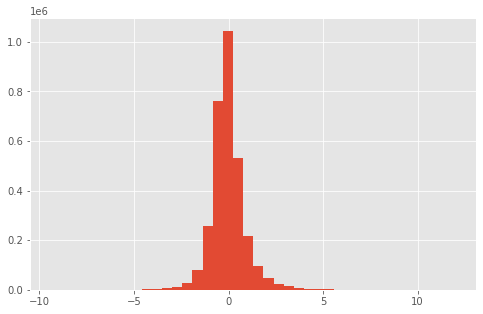

In [17]:
# distribution of histogram targets
plt.figure(figsize=(8, 5))
train['target'].hist(bins=40)

Text(0.5, 1.0, 'f_2')

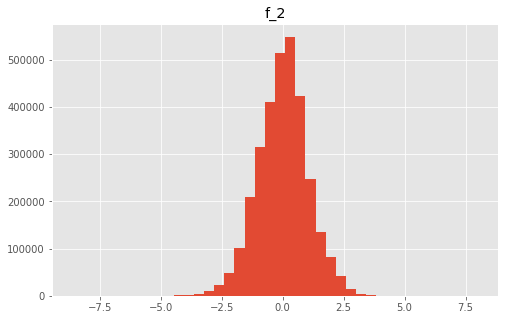

In [18]:
# distribution of random features
plt.figure(figsize=(8, 5))
feature = columns[np.random.randint(0,len(columns))]
train[feature].hist(bins=40)
plt.title(feature)

In [19]:
investment_id = 6
d = train.query('investment_id == @investment_id')
# d.set_index('time_id')['target']

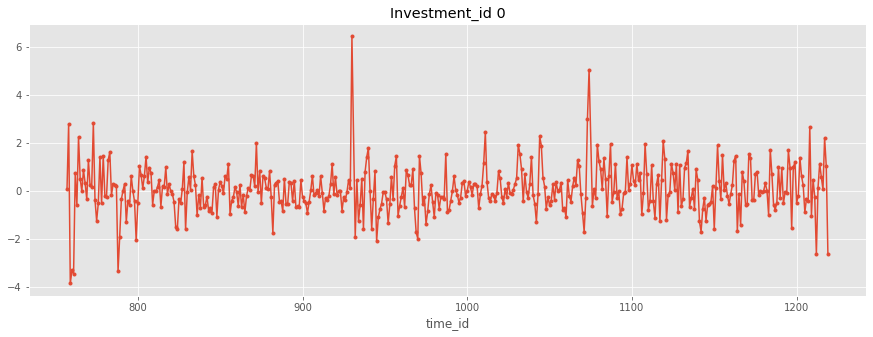

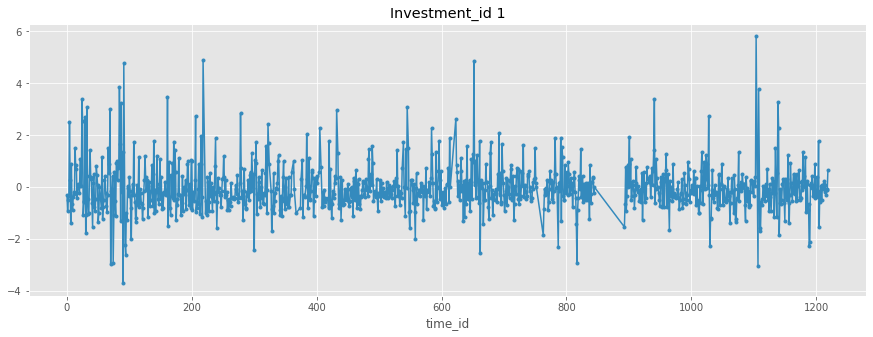

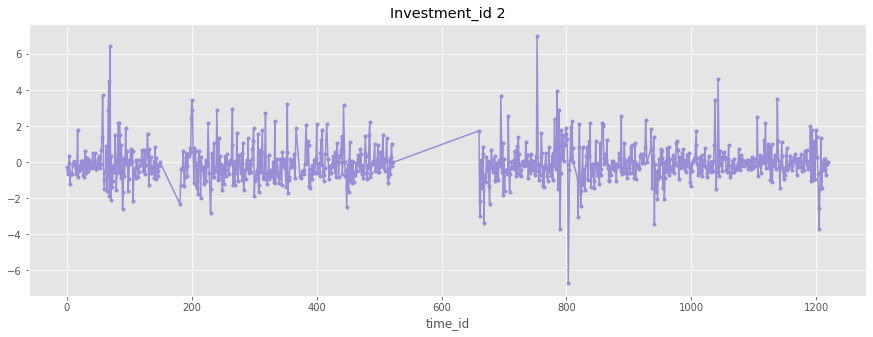

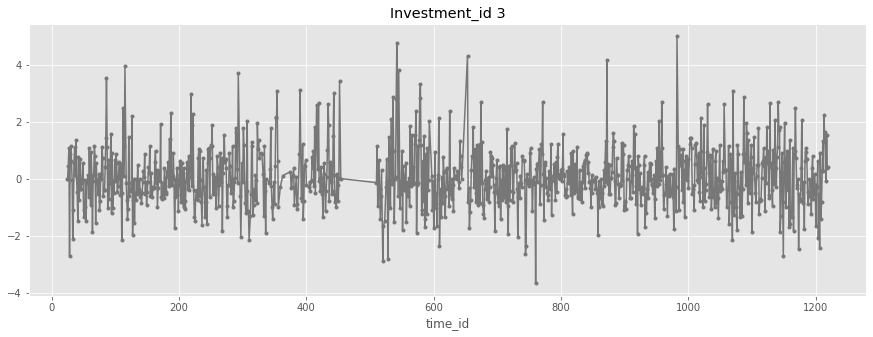

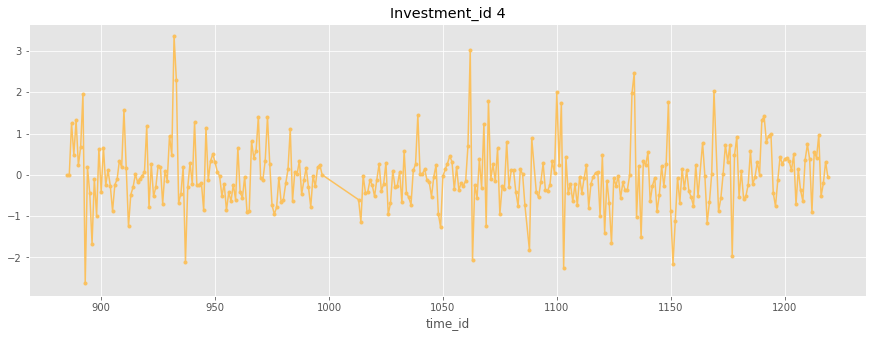

In [20]:
# example target for investment id
for investment_id in range(5):
    d = train.query('investment_id == @investment_id')
    d.set_index('time_id')['target'] \
        .plot(figsize=(15, 5),
              title=f'Investment_id {investment_id}',
              color=next(color_cycle),
              style='.-')
    plt.show()

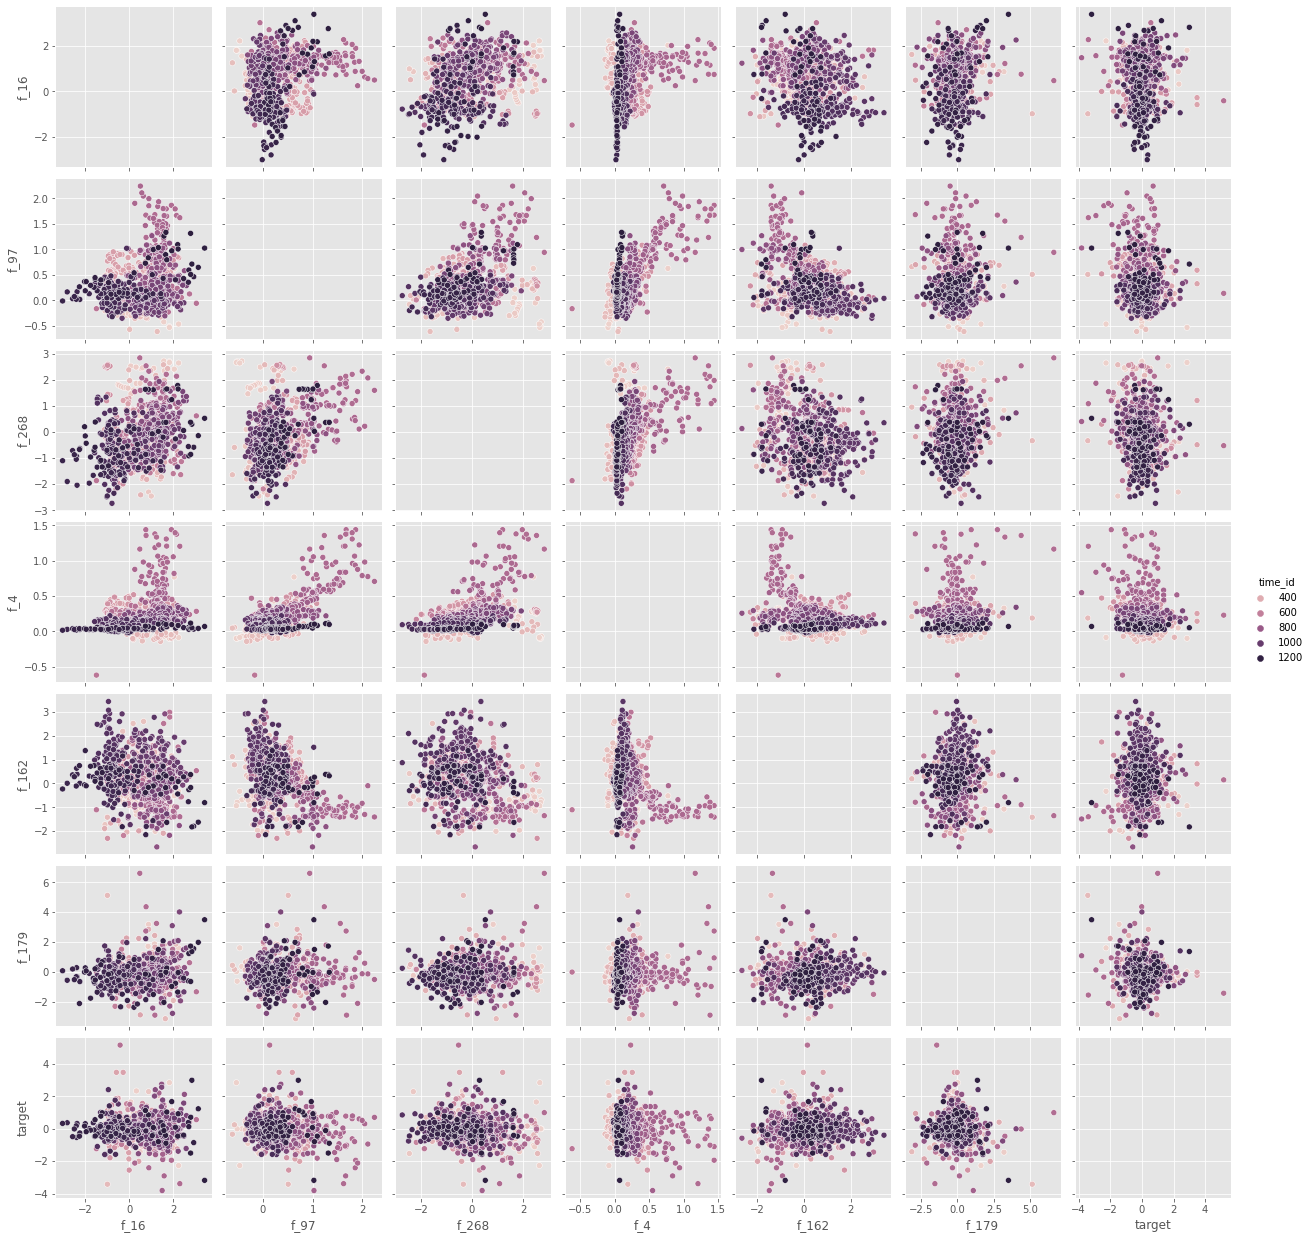

In [21]:
#  a pairplot of 10 random ids in the column section
investment_id = np.random.randint(0, train['investment_id'].nunique())

vars = list(set([columns[np.random.randint(4,len(columns))] for i in range(6)])) + ['target']

example_id = train.query('investment_id == @investment_id')
sns.pairplot(example_id,
             vars=vars,
            hue='time_id')
# diag_kind="hist"

## 2. Data preparation for loading
* Standardization of the investment id -  to minimize loss

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [23]:
def data_prep(df):
    
    scaler = StandardScaler()
    df_invest = (df['investment_id'].values).reshape(-1,1).astype(np.float64)
    scaled_data = scaler.fit_transform(df_invest)
    scaled_data = scaled_data.astype(np.float16)
    df_ = df[columns]
    df_invid = pd.DataFrame(scaled_data,columns = ['investment_id'])
    df_x = pd.concat([df_invid, df_],axis=1)
    df_x = df_x.values.reshape(df_x.shape+ (1,1))

    del df_
    del df_invid
    del scaled_data
    
    return df_x


In [24]:
# create a dataframe from the features for f_0
df_x = data_prep(train)

# del train for efficient memory utility
del train

In [25]:
# Work on training the model
# use of convolution neural network to reduce feature dimensions and train the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D, Conv1D,MaxPool1D,MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [26]:
# conv2d model
def basic_conv2D():
    new_model = Sequential()
    new_model.add(Conv2D(filters=32, kernel_size = 2, padding='same', activation='relu', input_shape=(301,1,1)))
    new_model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    new_model.add(Flatten())
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dense(64, activation='relu'))
    new_model.add(Dense(1))
    
    new_model.compile(metrics=[RootMeanSquaredError()],optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError()) 
    
    return new_model

m2 = basic_conv2D()

m2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 301, 1, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 151, 1, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4832)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               618624    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

2022-02-24 11:10:25.313504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 11:10:25.420210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 11:10:25.420931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 11:10:25.423797: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
# model training
kfold_generator = KFold(n_splits =5, shuffle=True, random_state =2022)
cp1 = ModelCheckpoint('m2', save_best_only=True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # Split training dataset.
    train_x, train_y = df_x[train_index], df_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = df_x[val_index], df_y.iloc[val_index]
#     Make data as arrays
    tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    del train_x
    del train_y
    print('deleted train_x and train_y')
    tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    del val_y
    del val_x
    
    
    m2 = basic_conv2D()
    
    m2.fit(tf_train, validation_data=(tf_val), epochs=10, callbacks=cp1)
    
    del tf_train
    del tf_val
    del m2

2022-02-24 11:10:29.958846: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.
2022-02-24 11:10:31.455094: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.


deleted train_x and train_y


2022-02-24 11:10:33.267435: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.
2022-02-24 11:10:34.300663: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.


Epoch 1/10


2022-02-24 11:10:35.736768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-24 11:10:36.559356: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2454/2454 [==============================] - 23s 7ms/step - loss: 0.8340 - root_mean_squared_error: 0.9132 - val_loss: 0.8431 - val_root_mean_squared_error: 0.9182


2022-02-24 11:10:58.933974: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-24 11:10:59.760884: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.


Epoch 2/10
2454/2454 [==============================] - 17s 7ms/step - loss: 0.8314 - root_mean_squared_error: 0.9118 - val_loss: 0.8425 - val_root_mean_squared_error: 0.9179
Epoch 3/10
2454/2454 [==============================] - 16s 7ms/step - loss: 0.8297 - root_mean_squared_error: 0.9109 - val_loss: 0.8405 - val_root_mean_squared_error: 0.9168
Epoch 4/10
2454/2454 [==============================] - 17s 7ms/step - loss: 0.8283 - root_mean_squared_error: 0.9101 - val_loss: 0.8396 - val_root_mean_squared_error: 0.9163
Epoch 5/10
2454/2454 [==============================] - 17s 7ms/step - loss: 0.8270 - root_mean_squared_error: 0.9094 - val_loss: 0.8396 - val_root_mean_squared_error: 0.9163
Epoch 6/10
2454/2454 [==============================] - 16s 7ms/step - loss: 0.8261 - root_mean_squared_error: 0.9089 - val_loss: 0.8391 - val_root_mean_squared_error: 0.9160
Epoch 7/10
2454/2454 [==============================] - 18s 7ms/step - loss: 0.8252 - root_mean_squared_error: 0.9084 - val_l

## Make inference

In [28]:
import ubiquant
best_model = tf.keras.models.load_model('/kaggle/working/m2/')
env = ubiquant.make_env()   
iter_test = env.iter_test()    
for (test_df, sample_prediction_df) in iter_test:
    test_df = data_prep(test_df)
    sample_prediction_df['target'] = best_model.predict(test_df)  
    env.predict(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
